In [6]:
import random
import pandas as pd
from math import log
import seaborn as sns
import matplotlib.pyplot as plt

# import pyecharts
# import numpy as np
# import csv

# import matplotlib
# import pyecharts.options as opts
# from pyecharts.globals import ThemeType
# from pyecharts.charts import Grid, Boxplot, Scatter, Pie, HeatMap, Bar, EffectScatter
# from pyecharts.commons.utils import JsCode
# from pyecharts.render import make_snapshot
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA


## 进行数据读入

In [6]:
buffer = pd.read_csv('pica2015.csv', header=0, encoding="utf-8", low_memory=False)
# print(buffer)
buffer.set_index('Unnamed: 0', inplace=True)
# buffer.head()
buffer.shape

(32130, 429)

In [5]:
# buffer.shape
buffer.columns
# buffer.index

Index(['CNTSCHID', 'Region', 'STRATUM', 'SUBNATIO', 'OECD', 'ADMINMODE',
       'Option_CPS', 'Option_FL', 'Option_ICTQ', 'Option_ECQ',
       ...
       'PV3SSES', 'PV4SSES', 'PV5SSES', 'PV6SSES', 'PV7SSES', 'PV8SSES',
       'PV9SSES', 'PV10SSES', 'SENWT', 'REPEAT'],
      dtype='object', length=429)

In [6]:
predict_buffer=buffer.loc[:,['ST001D01T','ST127Q01TA','ST127Q02TA','REPEAT']]
predict_buffer.head()
predict_buffer.shape

(32130, 4)

### 随机打乱索引

In [7]:
indices=[i for i in range(32130)]
random.shuffle(indices)


In [30]:
# 划分
validation_df=[]
for i in range(5):
    validation_df.append(predict_buffer.loc[indices[i*3213*2:(i+1)*3213*2],:])
print(validation_df[0].shape)

(6426, 4)


# Part 1

## 1 朴素贝叶斯

### 训练函数,验证函数

In [89]:
def bayes_train(bayes_training_set):
    y0_counts=len(bayes_training_set.loc[bayes_training_set['REPEAT']==0,'REPEAT'])
    y1_counts=len(bayes_training_set.loc[bayes_training_set['REPEAT']==1,'REPEAT'])
    dict1={}
    for xi in predict_buffer['ST001D01T'].unique():
        dict1[xi]={
            0:(len(bayes_training_set.loc[(bayes_training_set['ST001D01T']==xi)&(bayes_training_set['REPEAT']==0),'REPEAT'])+1)/(y0_counts+2),
            1:(len(bayes_training_set.loc[(bayes_training_set['ST001D01T']==xi)&(bayes_training_set['REPEAT']==1),'REPEAT'])+1)/(y1_counts+2)
        }

    dict2={}
    for xi in predict_buffer['ST127Q01TA'].unique():
        dict2[xi]={
            0:(len(bayes_training_set.loc[(bayes_training_set['ST127Q01TA']==xi)&(bayes_training_set['REPEAT']==0),'REPEAT'])+1)/(y0_counts+2),
            1:(len(bayes_training_set.loc[(bayes_training_set['ST127Q01TA']==xi)&(bayes_training_set['REPEAT']==1),'REPEAT'])+1)/(y1_counts+2)
        }

    dict3={}
    for xi in predict_buffer['ST127Q02TA'].unique():
        dict3[xi]={
            0:(len(bayes_training_set.loc[(bayes_training_set['ST127Q02TA']==xi)&(bayes_training_set['REPEAT']==0),'REPEAT'])+1)/(y0_counts+2),
            1:(len(bayes_training_set.loc[(bayes_training_set['ST127Q02TA']==xi)&(bayes_training_set['REPEAT']==1),'REPEAT'])+1)/(y1_counts+2)
        }

    dict_bayes={'ST001D01T':dict1, 'ST127Q01TA':dict2, 'ST127Q02TA':dict3}
    p_y0=y0_counts/(y0_counts+y1_counts)
    p_y1=y1_counts/(y0_counts+y1_counts)
    return dict_bayes,p_y0,p_y1

In [92]:
def bayes_validate(bayes_validation_set,dict_bayes, p_y0, p_y1):
    count=0
    for index in bayes_validation_set.index:
        row = bayes_validation_set.loc[index,:]
        value_y0 = dict_bayes['ST001D01T'][row['ST001D01T']][0] * dict_bayes['ST127Q01TA'][row['ST127Q01TA']][0] * dict_bayes['ST127Q02TA'][row['ST127Q02TA']][0] * p_y0
        value_y1= dict_bayes['ST001D01T'][row['ST001D01T']][1] * dict_bayes['ST127Q01TA'][row['ST127Q01TA']][1] * dict_bayes['ST127Q02TA'][row['ST127Q02TA']][1] * p_y1
        if value_y0>value_y1:
            prediction = 0
        elif value_y0<value_y1:
            prediction = 1
        else:
            input('equal?')
        if prediction==row['REPEAT']:
            count+=1
    print('accuracy:',count/(3213*2))
    return count/(3213*2)

### 交叉验证(k=5)

In [93]:
print('cross validating...')
ac_sum=0
for i in range(5):
    print('round {}:'.format(i+1))
    bayes_training_set=predict_buffer.loc[indices[:i*3213*2]+indices[(i+1)*3213*2:],:]
    bayes_validation_set=bayes_training_set=predict_buffer.loc[indices[i*3213*2:(i+1)*3213*2],:]
    dict_bayes, p_y0, p_y1 = bayes_train(bayes_training_set)
    ac_sum+=bayes_validate(bayes_validation_set, dict_bayes, p_y0, p_y1)
print('average accuracy:',ac_sum/5)

cross validating...
round 1:
accuracy: 0.9970432617491441
round 2:
accuracy: 0.9971988795518207
round 3:
accuracy: 0.9971988795518207
round 4:
accuracy: 0.9964207905384376
round 5:
accuracy: 0.997510115157174
average accuracy: 0.9970743853096794


## 2 决策树

### 实现

In [25]:
def get_disciminator(dataset):
    y0_count=len(dataset.loc[dataset['REPEAT']==0,'REPEAT'])
    y1_count=len(dataset.loc[dataset['REPEAT']==1,'REPEAT'])
    y0_rate=y0_count/(y0_count+y1_count)
    y1_rate=y1_count/(y0_count+y1_count)
    if y0_rate==0 or y1_rate==0:
        # print("???")
        return None

    entropy=-y0_rate*log(y0_rate)-y1_rate*log(y1_rate)
    best_gain=0
    discriminator=None
    for col in dataset.columns:
        if col=='REPEAT':
            continue
        gain=entropy
        for x in dataset.loc[:,col].unique().tolist():
            # print(x)
            count_0=len(dataset.loc[(dataset[col]==x)&(dataset['REPEAT']==0),'REPEAT'])
            count_1=len(dataset.loc[(dataset[col]==x)&(dataset['REPEAT']==1),'REPEAT'])
            rate0=count_0/(count_0+count_1)
            rate1=count_1/(count_0+count_1)
            # print(count_0,count_1)
            if count_0!=0 and count_1!=0:
                gain-=((count_0+count_1)/(y0_count+y1_count))*(-rate0*log(rate0)-rate1*log(rate1))
        # print(gain)
        if gain>best_gain:
            discriminator=col
            best_gain=gain
    return discriminator

def split(dataset,discriminator):
    subset={}
    for value in dataset.loc[:,discriminator].unique().tolist():
        subset[value]=dataset.loc[(dataset[discriminator]==value),:]
    return subset

In [51]:
class decision_tree(object):
    def __init__(self, dataset):
        self.Child_node={}
        self.d=get_disciminator(dataset)
        self.predict=-1
        self.label=int(len(dataset.loc[dataset['REPEAT']==0,'REPEAT']) < len(dataset.loc[dataset['REPEAT']==1,'REPEAT']))
        # print(self.d)
        if self.d!=None:
            subset=split(dataset,self.d)
            for set in subset.keys():
                # print(set)
                self.Child_node[set]=decision_tree(subset[set])
        else:
            self.predict=self.label

    def classify(self,x):
        if self.predict!=-1:
            return self.predict
        else:
            # print(x[self.d])
            # print(self.Child_node[x[self.d]])
            try:
                return self.Child_node[x[self.d]].classify(x)
            except:
                # print(self.d,self.Child_node.keys(),x[self.d])
                # input("???")
                return self.label
    
    def print_tree(self):
        print(self.d)
        for child in self.Child_node.values():
            child.print_tree()


### 测试

In [52]:
print('cross validating...')
ac_sum=0

for i in range(5):
    print('round {}:'.format(i+1))
    correct=0
    training_set=predict_buffer.loc[indices[:i*3213*2]+indices[(i+1)*3213*2:],:]
    validation_set=predict_buffer.loc[indices[i*3213*2:(i+1)*3213*2],:]
    my_tree=decision_tree(training_set)
    for index,row in validation_set.iterrows():
        if row['REPEAT']==my_tree.classify(row):
            correct+=1
    print('accuracy:',correct/(3213*2))
    ac_sum+=correct/(3213*2)
print('average accuracy:',ac_sum/5)

cross validating...
round 1:
accuracy: 0.9998443821973234
round 2:
accuracy: 1.0
round 3:
accuracy: 0.9998443821973234
round 4:
accuracy: 0.9998443821973234
round 5:
accuracy: 1.0
average accuracy: 0.999906629318394


# Part 2

## 导入训练集标签

In [2]:
labels = pd.read_csv('label_train.csv', header=0, encoding="utf-8", low_memory=False)
# labels.set_index('Unnamed: 0', inplace=True)
labels.set_index('Unnamed: 0', inplace=True)
labels

,index,MATH
Unnamed: 0,,
6426,6426,520.378
6427,6427,563.734
6428,6428,597.299
6429,6429,421.818
6430,6430,511.234
...,...,...
32125,32125,396.169
32126,32126,398.557
32127,32127,396.373


#### 删去取值唯一属性和object类属性

In [3]:
df = pd.read_csv('pica2015.csv', header=0, encoding="utf-8", low_memory=False)
df.set_index('Unnamed: 0', inplace=True)
one_value_col = []
for col in list(df.columns):
    if len(df[col].unique()) == 1:
        one_value_col.append(col)
print(one_value_col)
df = df.drop(one_value_col, axis=1)
datatype = df.dtypes
datatype = datatype[datatype=='object']
df = df.drop(list(datatype.index), axis=1)
# df.shape
# df.head()
df = df.loc[6426:,:]
df

['OECD', 'ADMINMODE', 'Option_CPS', 'Option_FL', 'Option_ICTQ', 'Option_ECQ', 'Option_PQ', 'Option_TQ', 'Option_UH', 'Option_Read', 'Option_Math', 'ST003D03T', 'ST006Q04TA', 'ST008Q04TA', 'ST124Q01TA', 'ST127Q03TA']


,CNTSCHID,Region,SUBNATIO,LANGTEST_QQQ,LANGTEST_COG,CBASCI,BOOKID,ST001D01T,ST003D02T,ST004D01T,...,PV3SSES,PV4SSES,PV5SSES,PV6SSES,PV7SSES,PV8SSES,PV9SSES,PV10SSES,SENWT,REPEAT
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
6426,97100196,72404,7240400,160,160,6,94,10,7,2,...,411.089,491.040,523.839,531.440,499.505,488.832,487.122,489.874,0.05695,0
6427,97100196,72404,7240400,160,160,1,50,10,7,2,...,562.589,528.294,601.008,551.440,529.370,587.628,618.553,547.610,0.05695,0
6428,97100196,72404,7240400,160,160,2,39,10,7,2,...,535.619,505.339,427.786,450.275,503.253,517.877,576.331,488.961,0.05695,0
6429,97100196,72404,7240400,160,160,3,51,10,7,2,...,377.807,390.791,397.509,418.882,374.070,413.413,403.846,403.550,0.05695,0
6430,97100196,72404,7240400,160,160,4,95,10,7,2,...,499.929,484.723,508.225,531.021,498.783,485.738,489.025,554.735,0.05695,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32125,97100980,72416,7241600,156,156,7,51,9,1,2,...,333.743,443.126,415.404,407.680,355.131,380.074,354.619,339.136,0.03523,1
32126,97100980,72416,7241600,156,156,1,95,9,10,2,...,254.325,199.116,360.027,319.380,272.180,356.742,311.945,353.375,0.03523,1
32127,97100980,72416,7241600,156,156,3,37,9,7,2,...,345.183,335.601,397.349,327.727,318.283,343.219,382.890,317.025,0.03523,1


In [4]:
df = pd.concat([df, labels.loc[:,'MATH']], axis=1)
corr=df.corr()

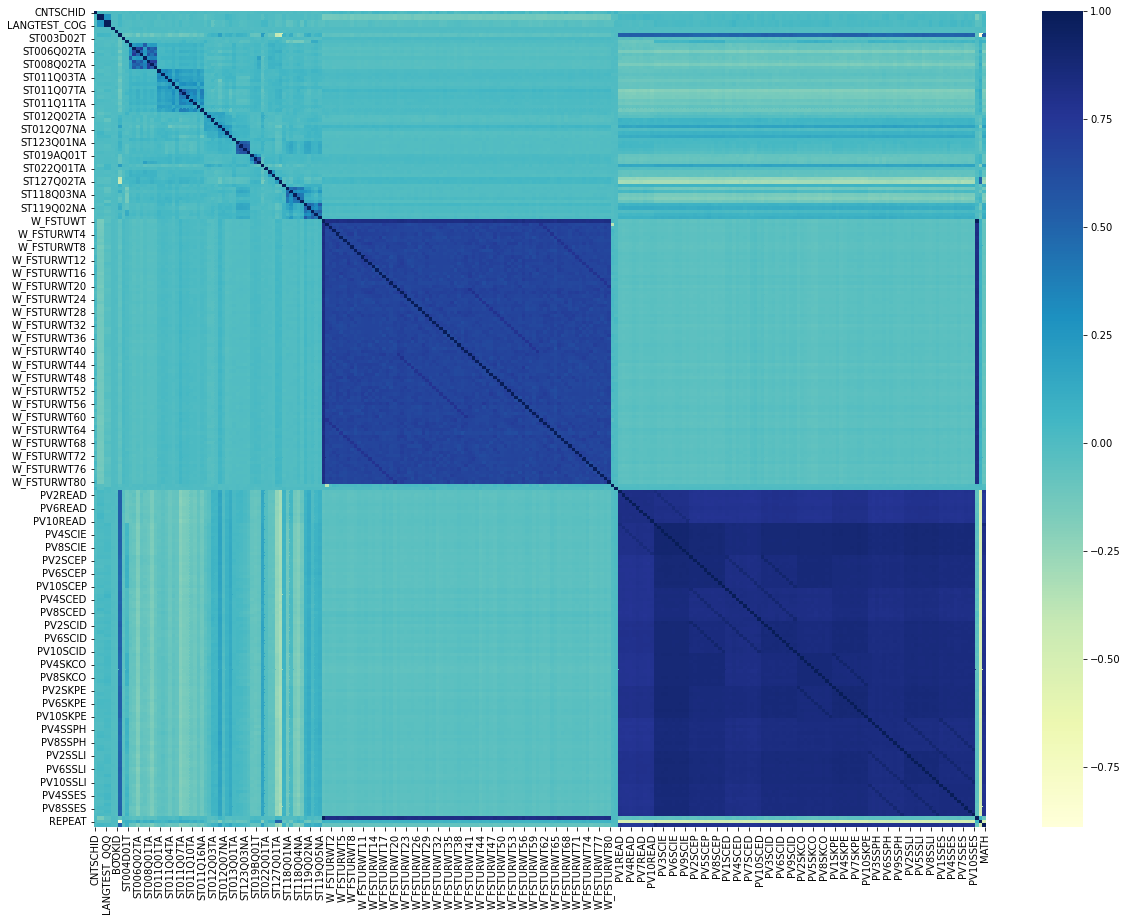

In [16]:
plt.figure(figsize=(20, 15))
sns.heatmap(corr,linewidths=0,linecolor='black',cmap='YlGnBu')
# plt.show()

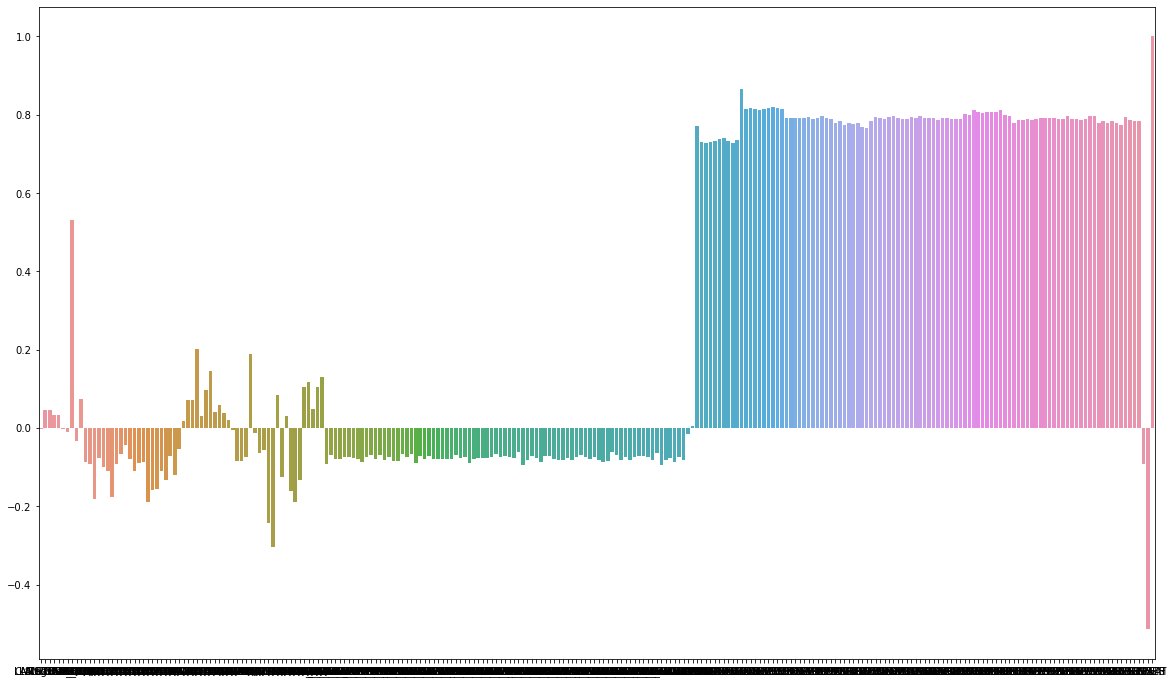

In [25]:
plt.figure(figsize=(20, 12))
sns.barplot(x=corr.columns.to_list(),y=corr.loc['MATH',:].to_list())

### 剔除object类型属性

In [9]:
buffer.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [10]:
datatype = buffer.dtypes
# datatype
datatype = datatype[datatype=='object']
# datatype.index
df_no_object = buffer.drop(list(datatype.index), axis=1)
df_no_object.shape
df_no_object.head()

,CNTSCHID,Region,SUBNATIO,LANGTEST_QQQ,LANGTEST_COG,CBASCI,BOOKID,ST001D01T,ST003D02T,ST004D01T,...,PV3SSES,PV4SSES,PV5SSES,PV6SSES,PV7SSES,PV8SSES,PV9SSES,PV10SSES,SENWT,REPEAT
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,97100001,72409,7240900,160,160,2,41,8,6,1,...,219.875,303.038,285.110,273.971,207.956,314.248,375.058,277.122,0.61951,1
1,97100001,72409,7240900,160,160,1,32,8,6,2,...,364.385,302.733,327.340,364.538,390.651,420.026,353.710,402.950,0.70697,1
2,97100001,72409,7240900,160,160,4,93,8,4,2,...,393.415,313.403,352.497,396.071,399.086,383.038,365.690,350.367,0.70697,1
3,97100001,72409,7240900,160,160,7,33,9,11,1,...,408.821,490.702,488.315,507.399,520.479,490.148,417.544,405.723,0.61951,1
4,97100001,72409,7240900,160,160,3,89,9,7,1,...,438.807,446.787,408.045,473.160,474.723,393.110,489.057,465.089,0.61951,1


## 相关系数总体分析

### 计算相关系数

In [11]:
corr_df = df_no_object.corr()
# corr_df[corr_df.isnull().T.any()]

### 绘图

In [13]:
repeat_corr = corr_df['REPEAT']

## 根据相关系数选择特征

### 与REPEAT相关系数绝对值大于0.7的特征

- ST001D01T属性与REPEAT相关性非常高,考虑作为特征

In [15]:
feature_group1 = repeat_corr[abs(repeat_corr)>0.7]
feature_group1

ST001D01T   -0.890272
REPEAT       1.000000
Name: REPEAT, dtype: float64

- ST001D01T为学生年级属性,无非法值

In [16]:
df_no_object['ST001D01T'].unique().tolist()

[8, 9, 10, 7, 11]

- 使用饼图研究ST001D01T与REPEAT的关系

In [17]:
grade_repeat_distribution = []
grade_repeat_datapair = []
for g in sorted(df_no_object['ST001D01T'].unique().tolist()):
    # print(g)
    grade_repeat_distribution.append(df_no_object.loc[df_no_object['ST001D01T']==g,'REPEAT'].value_counts())
# print(grade_repeat_distribution)
for d in grade_repeat_distribution:
    # print(d[0])
    dp_temp=[list(z) for z in zip(['REPEAT','NOT REPEAT'],  [d[1],d[0]])]
    dp_temp[0][1]/=1
    dp_temp[1][1]/=1
    grade_repeat_datapair.append(dp_temp)
# print(grade_repeat_datapair)

- 可以看到,高年级(10-11)学生复读率非常低，而低年级学生(7-9)复读率非常高

### 与REPEAT相关系数绝对值在(0.3,0.7]的特征

In [19]:
feature_group2 = repeat_corr[(abs(repeat_corr)>0.3) & (abs(repeat_corr)<=0.7)]
feature_group2

ST127Q01TA    0.503665
ST127Q02TA    0.493093
PV1READ      -0.512880
PV2READ      -0.513416
PV3READ      -0.508939
                ...   
PV6SSES      -0.489689
PV7SSES      -0.499948
PV8SSES      -0.500142
PV9SSES      -0.495501
PV10SSES     -0.506471
Name: REPEAT, Length: 102, dtype: float64

- 根据前面的相关系数直方图和热力图,ST127Q01TA,ST127Q02TA属性与REPEAT相关系数在0.5左右,
  
  PV1READ-PV10SSES一系列属性与REPEAT相关系数在-0.5左右,考虑分为两组进行分析

#### ST127Q01TA,ST127Q02TA属性

- ST127Q01TA,ST127Q02TA属性是对学生复读次数的统计,但有一部分无效值(9),导致与REPEAT相关系数与1相差较大

In [20]:
print(df_no_object['ST127Q01TA'].value_counts())
print(df_no_object['ST127Q02TA'].value_counts())

1    26348
2     3366
9     2238
3      178
Name: ST127Q01TA, dtype: int64
1    23751
2     6966
9      906
3      507
Name: ST127Q02TA, dtype: int64


- 考虑替换无效值9为其余值的均值

In [21]:
df_rp_ts = df_no_object.loc[:,['REPEAT','ST127Q01TA','ST127Q02TA']]
df_rp_ts

,REPEAT,ST127Q01TA,ST127Q02TA
Unnamed: 0,,,
0,1,2,2
1,1,1,3
2,1,2,2
3,1,1,2
4,1,1,2
...,...,...,...
32125,1,1,2
32126,1,9,2
32127,1,1,2


In [22]:
df_rp_ts.loc[df_rp_ts['ST127Q01TA']==9,'ST127Q01TA']=(1*26348+2*3366+3*178)/(26348+3366+178)
df_rp_ts.loc[df_rp_ts['ST127Q02TA']==9,'ST127Q02TA']=(1*23751+2*6966+3*507)/(23751+6966+507)
df_rp_ts.value_counts()

REPEAT  ST127Q01TA  ST127Q02TA
0       1.000000    1.000000      22756
1       1.000000    2.000000       3200
        1.124515    2.000000       1986
        2.000000    2.000000       1752
                    1.000000        904
                    1.255573        663
        1.000000    3.000000        250
        1.124515    3.000000        175
0       1.000000    1.255573        142
1       3.000000    1.255573        101
0       1.124515    1.000000         77
1       2.000000    3.000000         47
        3.000000    3.000000         35
                    2.000000         28
                    1.000000         14
dtype: int64

In [23]:
df_rp_ts.corr()

,REPEAT,ST127Q01TA,ST127Q02TA
REPEAT,1.000000,0.586125,0.864852
ST127Q01TA,0.586125,1.000000,0.305456
ST127Q02TA,0.864852,0.305456,1.000000


- 可以看到与REPEAT列相关性提升了,
  
  事实上也可以考虑将非法值所在行删去,或者将1(0次复读)和2-3(1次及以上复读)直接归为0/1两类,再进行处理,或对两个属性求平均等等

#### PV1READ-PV10SSES系列属性

- 根据前面的相关系数热力图,PV1READ-PV10SSE系列属性互相之间相关系数非常高,考虑进行PCA分析抽取特征

- 先选取一部分属性: PV1READ-PV10READ,PV1SCIE-PV10SCIE绘制箱图进行研究

In [24]:
df_to_box = df_no_object.loc[:,'PV1READ':'PV10SCIE']
# df_to_box.head()
# df_to_box['PV1READ'].tolist()
df_to_box.columns.tolist()

['PV1READ',
 'PV2READ',
 'PV3READ',
 'PV4READ',
 'PV5READ',
 'PV6READ',
 'PV7READ',
 'PV8READ',
 'PV9READ',
 'PV10READ',
 'PV1SCIE',
 'PV2SCIE',
 'PV3SCIE',
 'PV4SCIE',
 'PV5SCIE',
 'PV6SCIE',
 'PV7SCIE',
 'PV8SCIE',
 'PV9SCIE',
 'PV10SCIE']

- 可以看到的各个属性的分布都非常相似

- 对PV1READ-PV10SSES系列属性进行PCA分析和特征抽取

In [26]:
df_to_pca = df_no_object.loc[:,'PV1READ':'PV10SSES']

In [27]:
x = StandardScaler().fit_transform(df_to_pca)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
pca.explained_variance_ratio_
# principalComponents

array([0.84293107, 0.01172538, 0.00530852])

- 第一个主成分包含84.29%的方差(可以理解为信息),其余主成分包含信息非常少,
  
  则考虑使用第一个主成分作为这个属性系列抽取的特征

- 将principal component 1取整,统计每个principal component 1取值上REPEAT的均值

In [28]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
finalDf = pd.concat([principalDf, df_no_object[['REPEAT']]], axis = 1)
# finalDf.corr()
# finalDf['REPEAT'].tolist()
pc1_rpt = finalDf.loc[:,['principal component 1','REPEAT']]
pc1_rpt.loc[:,'principal component 1']=round(pc1_rpt['principal component 1'])
pc1_rpt_counts=pc1_rpt.value_counts()

In [29]:
pc1_rpt_dict={}
for i in pc1_rpt_counts.index:
    if i[0] not in pc1_rpt_dict.keys():
        pc1_rpt_dict[i[0]]={}
        pc1_rpt_dict[i[0]][i[1]]=pc1_rpt_counts[i]
        pc1_rpt_dict[i[0]][i[1]^1]=0
    else:
        pc1_rpt_dict[i[0]][i[1]]=pc1_rpt_counts[i]
    # print(i[0])
    # print(pc1_rpt_counts[i])
    # break
# pc1_rpt_dict
x_data_pc1=sorted(pc1_rpt_dict.keys())
y_data_rpt=[]
for x in x_data_pc1:
    y_data_rpt.append(pc1_rpt_dict[x][1]/(pc1_rpt_dict[x][1]+pc1_rpt_dict[x][0]))
# y_data_rpt